In [1]:
# data manipulation 
import numpy as np
import pandas as pd

# Time-manipulation libraries:
from datetime import datetime
from time import strftime
import itertools

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Split/Modeling libraries:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# web-based requests
import requests

# Importing the os library specifically for reading the csv once I've created the file in my working directory.
import os

# My functions:
import acquire
import prepare
# import explore - need to complete this soon!

credentials loaded successfully
End of file.


## Plan:

##### Using different dataset than in the lesson - using stock data provided by Ryan and Zach.

- Plan for this project MVP is simply to walk through the steps we learned in the lesson, to get a baseline. 
- Then, I want to create moving averages
- Then create bollinger bands
- End up with crossover and B-band breakouts noted
- Finally, attempt predicting future performance based on those conditions.

## Acquiring the Data

In [2]:
# Acquring data from csv located at: http://www.cboe.com/micro/buywrite/dailypricehistory.xls

In [3]:
df = pd.read_csv('cboe_data_spx.csv')
print(df.shape)
df.head()

(8337, 2)


,date,spx
0,30-Jun-86,250.84
1,01-Jul-86,252.04
2,02-Jul-86,252.70
3,03-Jul-86,251.79
4,07-Jul-86,244.05


In [4]:
df.isnull().sum()

date    0
spx     0
dtype: int64

In [5]:
df.date = pd.to_datetime(df.date)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8337 entries, 0 to 8336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8337 non-null   datetime64[ns]
 1   spx     8337 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 130.4 KB


In [7]:
df = df.set_index('date').sort_index()
df

,spx
date,
1986-06-30,250.84
1986-07-01,252.04
1986-07-02,252.70
1986-07-03,251.79
1986-07-07,244.05
...,...
2019-07-22,2985.03
2019-07-23,3005.47
2019-07-24,3019.56


In [8]:
df.index.dtype

dtype('<M8[ns]')

## Prepare

- This data has missing days because of weekends, so I need to figure out what to do with that.

In [9]:
df.resample("D").mean().ffill(axis = 0).head(10)

,spx
date,
1986-06-30,250.84
1986-07-01,252.04
1986-07-02,252.70
1986-07-03,251.79
1986-07-04,251.79
1986-07-05,251.79
1986-07-06,251.79
1986-07-07,244.05
1986-07-08,241.59


In [10]:
df = df.resample("D").mean().ffill(axis = 0)
df

,spx
date,
1986-06-30,250.84
1986-07-01,252.04
1986-07-02,252.70
1986-07-03,251.79
1986-07-04,251.79
...,...
2019-07-22,2985.03
2019-07-23,3005.47
2019-07-24,3019.56


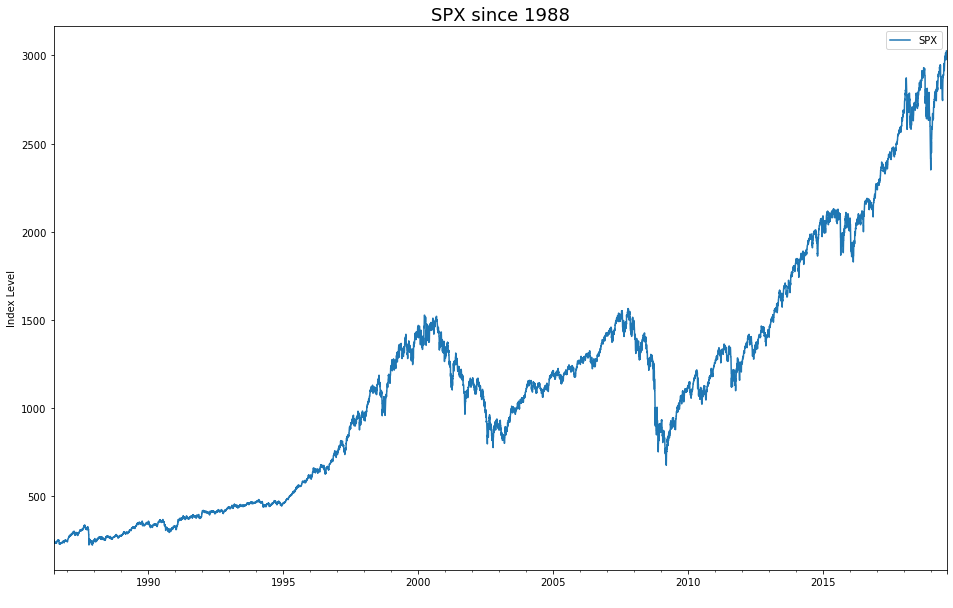

In [11]:
df.plot(figsize = (16, 10))
plt.legend(['SPX'])
plt.title("SPX since 1988", fontsize = 18)
plt.xlabel(" ")
plt.ylabel("Index Level")
plt.show()

### Splitting the data

In [12]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size + validate_size)
validate_end_index = train_size + validate_size

# split into train, validate, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index :]

In [13]:
train

,spx
date,
1986-06-30,250.84
1986-07-01,252.04
1986-07-02,252.70
1986-07-03,251.79
1986-07-04,251.79
...,...
2003-01-07,922.93
2003-01-08,909.93
2003-01-09,927.58


In [14]:
print(len(train), len(validate), len(test))

6040 3624 2416


In [15]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [16]:
print(df.head(1) == train.head(1))

             spx
date            
1986-06-30  True


In [17]:
pd.concat([train.tail(1), validate.head(1)])
# pd.concat([validate.tail(1), test.head(1)])

,spx
date,
2003-01-11,927.57
2003-01-12,927.57


In [18]:
pd.concat([test.tail(1), df.tail(1)])

,spx
date,
2019-07-26,3025.86
2019-07-26,3025.86


In [19]:
train.index.dtype

dtype('<M8[ns]')

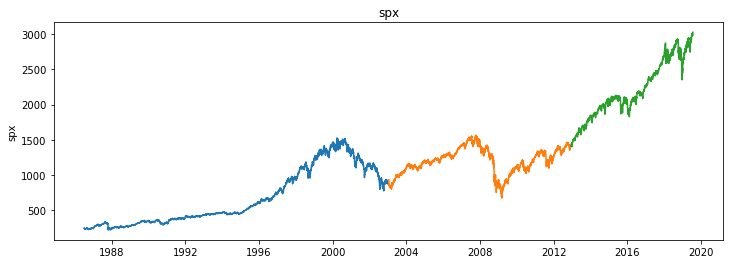

In [20]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Explore

<AxesSubplot:xlabel='date'>

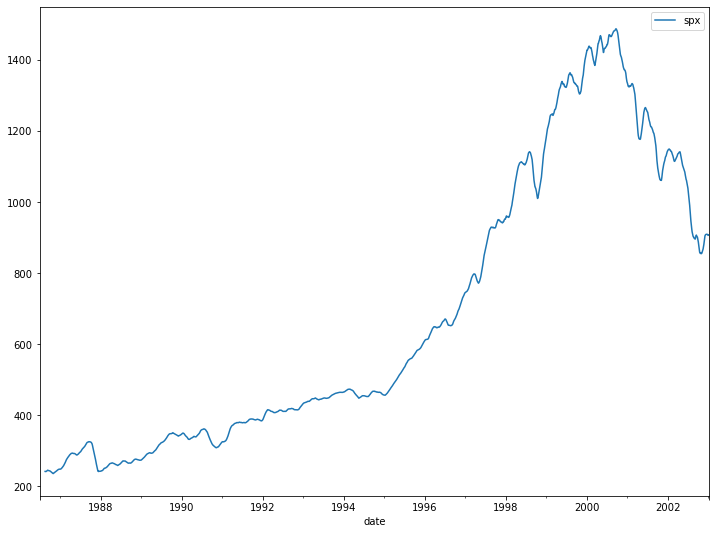

In [21]:
# Moving average (50 day):

train.rolling(50).mean().plot(figsize = (12, 9))

<AxesSubplot:xlabel='date'>

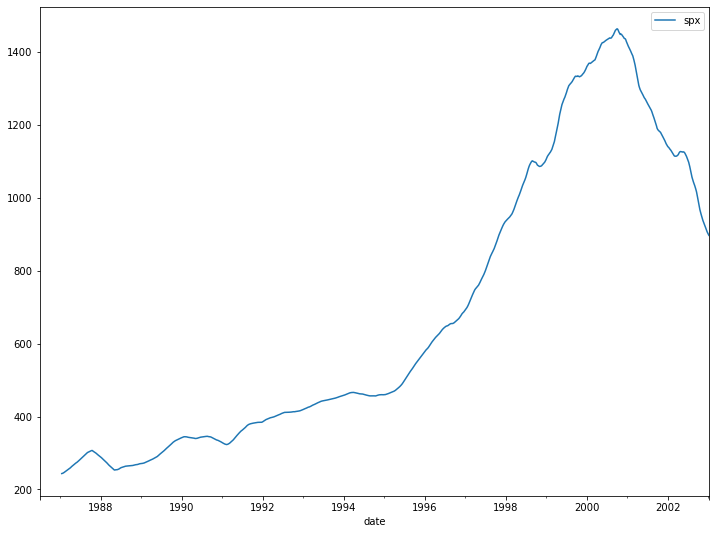

In [22]:
# Moving average (200 day):

train.rolling(200).mean().plot(figsize = (12, 9))

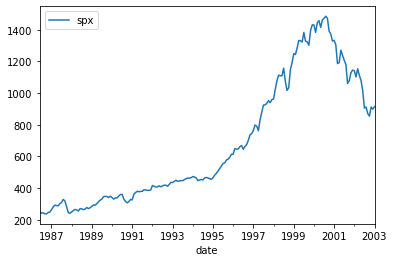

In [23]:
# Monthly average:

train.resample("MS").mean().plot()
plt.show()

<AxesSubplot:xlabel='date'>

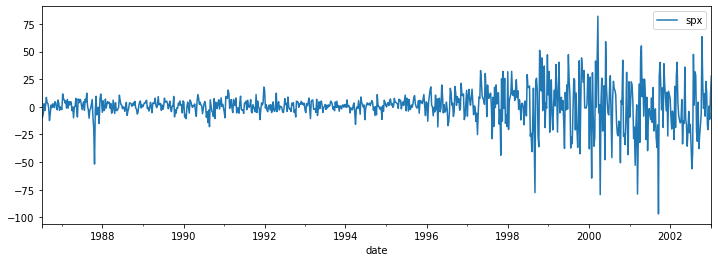

In [24]:
# Moving difference:

train.resample("W").mean().diff(periods = 1).plot(figsize = (12, 4))

<AxesSubplot:xlabel='date'>

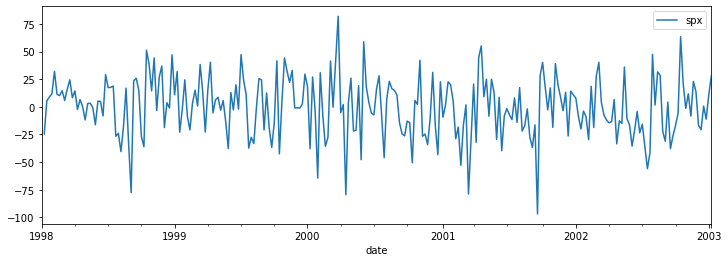

In [25]:
# Obviously a lot noisier near the end of the data timeframe, but is that just because of higher levels? 
# I haven't normalized for that.

# Looking just at the last few years of the train dataset:


train["1998":].resample("W").mean().diff(periods = 1).plot(figsize = (12, 4))

#### Takeaway:
- The moving difference is much less variable.
- Still no decernable pattern, but less range of variation.

<AxesSubplot:xlabel='date'>

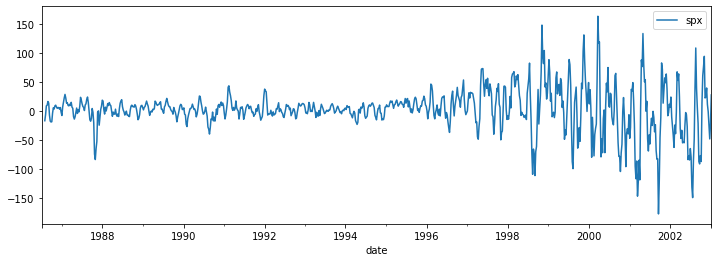

In [26]:
# Moving difference resampling at lower frequency (less samples):

train.resample("W").mean().diff(periods = 4).plot(figsize = (12, 4))

#### Trying to see if there are any seasonality trends I can see

- From the old trader's adage, "Sell in May and stay away", meaning that going to cash over the summer months and coming back to invest in the fall implies a sort of seasonal trend.

In [27]:
train_explore = train.copy()

In [28]:
train_explore['month'] = train_explore.index.month
train_explore.head()

,spx,month
date,,
1986-06-30,250.84,6
1986-07-01,252.04,7
1986-07-02,252.70,7
1986-07-03,251.79,7
1986-07-04,251.79,7


<AxesSubplot:xlabel='month', ylabel='spx'>

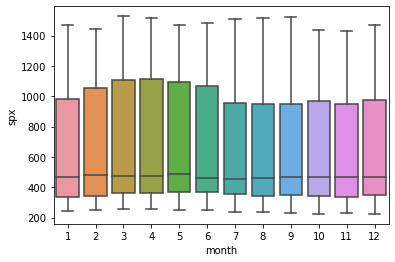

In [29]:
# The summer months are 5 - 8. So can I group by those months?

sns.boxplot(data = train_explore, x = 'month', y = 'spx')

<AxesSubplot:xlabel='month', ylabel='spx'>

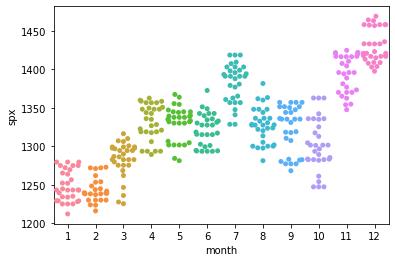

In [30]:
sns.swarmplot(data = train_explore["1999"], x = 'month', y = 'spx')

## Bollinger Bands

- first showing manually, then by using TA-lib

In [31]:
train_bb = train.copy()

In [32]:
# for col in train_bb.columns:

train_bb.rolling(window = 20).mean().isnull().sum()

spx    19
dtype: int64

In [33]:
train_bb.rolling(window = 20).std().isnull().sum()

spx    19
dtype: int64

In [34]:
train_bb['20_day_ma'] = train_bb['spx'].rolling(window=20).mean()

<AxesSubplot:xlabel='date'>

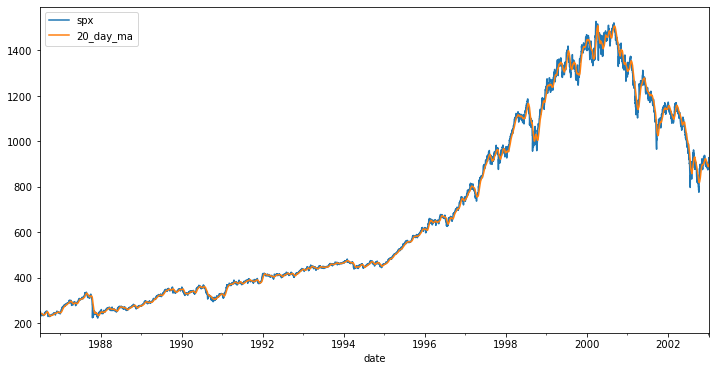

In [35]:
train_bb.plot(figsize = (12, 6))

In [36]:
train_bb['20_day_st_dev'] = train_bb['spx'].rolling(window=20).std()

In [37]:
train_bb['upper_band'] = train_bb['20_day_ma'] + (train_bb['20_day_st_dev'] * 2)
train_bb['lower_band'] = train_bb['20_day_ma'] - (train_bb['20_day_st_dev'] * 2)
train_bb

,spx,20_day_ma,20_day_st_dev,upper_band,lower_band
date,,,,,
1986-06-30,250.84,NaN,NaN,NaN,NaN
1986-07-01,252.04,NaN,NaN,NaN,NaN
1986-07-02,252.70,NaN,NaN,NaN,NaN
1986-07-03,251.79,NaN,NaN,NaN,NaN
1986-07-04,251.79,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2003-01-07,922.93,894.7725,15.741136,926.254772,863.290228
2003-01-08,909.93,896.0565,15.884348,927.825195,864.287805
2003-01-09,927.58,897.6480,17.376507,932.401015,862.894985


In [38]:
# I'm choosing to simply drop the first 20 dates.

train_bb = train_bb.dropna()

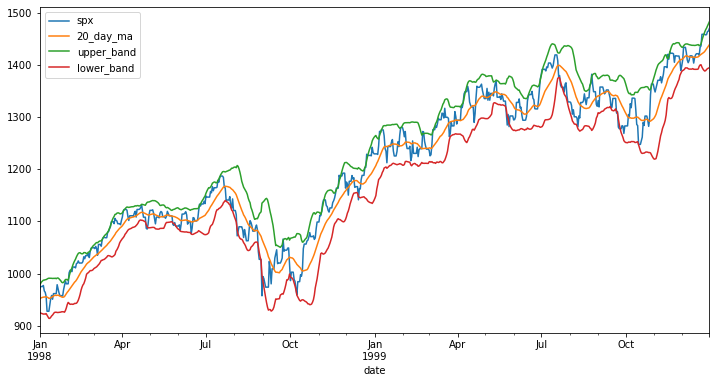

In [39]:
spx_df = train_bb['1998':'1999'][['spx', '20_day_ma', 'upper_band', 'lower_band']].plot(figsize = (12, 6))

In [40]:
spx_small = train_bb['1998':'2001']
spx_small

,spx,20_day_ma,20_day_st_dev,upper_band,lower_band
date,,,,,
1998-01-01,970.43,951.6030,13.254193,978.111387,925.094613
1998-01-02,975.04,952.6855,14.254201,981.193902,924.177098
1998-01-03,975.04,953.7680,15.107081,983.982162,923.553838
1998-01-04,975.04,954.3505,15.710176,985.770852,922.930148
1998-01-05,977.07,954.8020,16.244965,987.291931,922.312069
...,...,...,...,...,...
2001-12-27,1157.13,1140.8135,11.669443,1164.152387,1117.474613
2001-12-28,1161.02,1140.9490,11.896816,1164.742631,1117.155369
2001-12-29,1161.02,1141.0845,12.118328,1165.321156,1116.847844


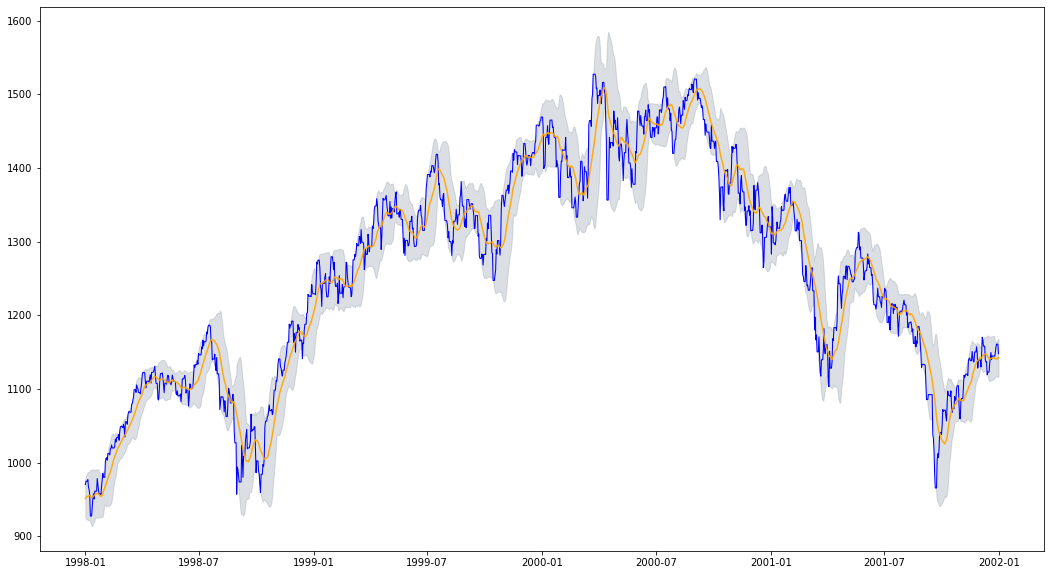

In [41]:
# plt.style.use('fivethirtyeight')
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)

x_axis = spx_small.index.get_level_values(0)

ax.fill_between(x_axis, spx_small['upper_band'], spx_small['lower_band'], color = 'slategrey', alpha = .25)

ax.plot(x_axis, spx_small['spx'], color = 'blue', linewidth = '1.05')
ax.plot(x_axis, spx_small['20_day_ma'], color = 'orange', alpha = .91)

plt.show()

In [42]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

## Using TA-lib

In [43]:
import pandas_datareader.data as web
import talib as ta
import quandl

In [44]:
explore_df = train.copy()
explore_df

,spx
date,
1986-06-30,250.84
1986-07-01,252.04
1986-07-02,252.70
1986-07-03,251.79
1986-07-04,251.79
...,...
2003-01-07,922.93
2003-01-08,909.93
2003-01-09,927.58


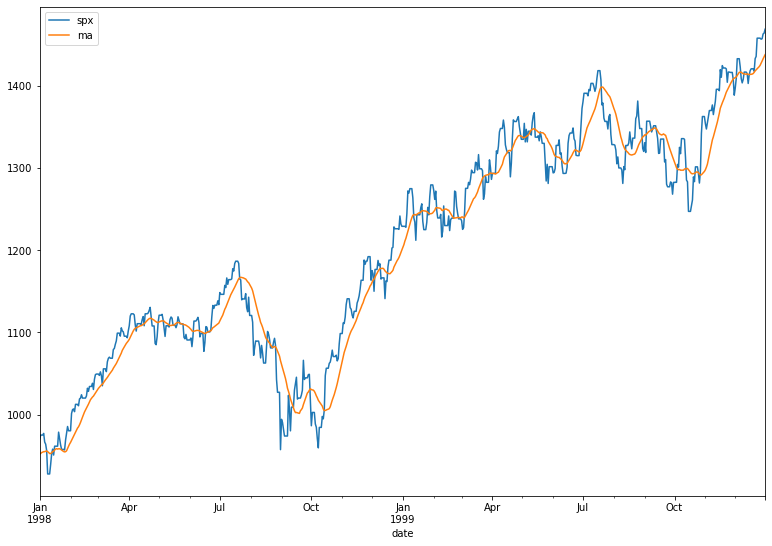

In [45]:
explore_df['ma'] = ta.SMA(explore_df['spx'], 20)
explore_df['1998':'1999'][['spx', 'ma']].plot(figsize = (13, 9))
plt.show()

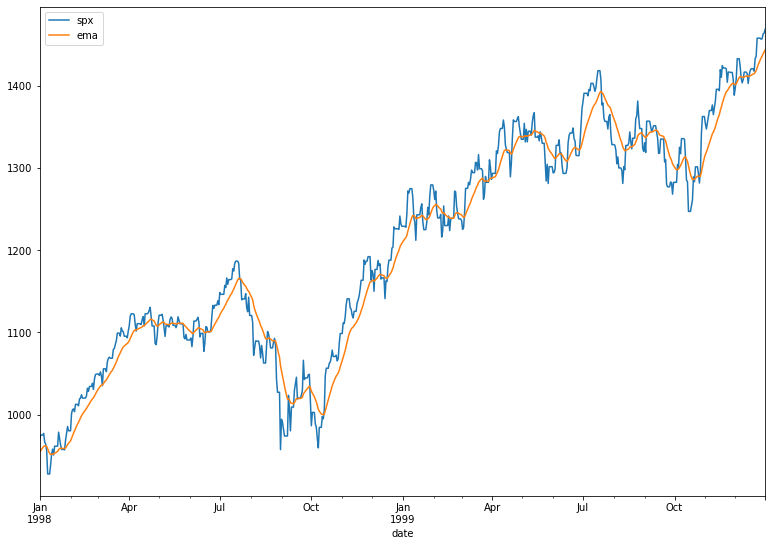

In [46]:
explore_df['ema'] = ta.EMA(explore_df['spx'], 20)
explore_df['1998':'1999'][['spx', 'ema']].plot(figsize = (13, 9))
plt.show()

In [47]:
explore_df['up_band'], explore_df['mid_band'], explore_df['low_band'] = ta.BBANDS(explore_df['spx'], timeperiod = 20)

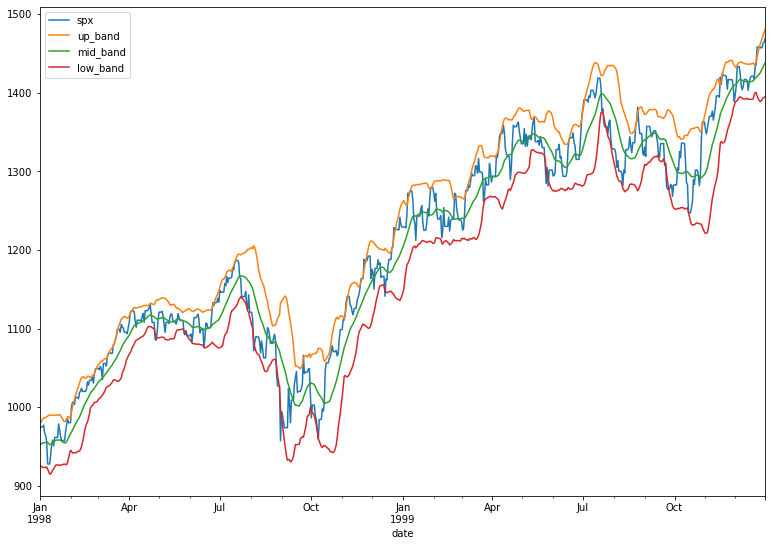

In [48]:
explore_df['1998':'1999'][['spx', 'up_band', 'mid_band', 'low_band']].plot(figsize = (13, 9))
plt.show()

In [49]:
ta.BBANDS?

#### Relative Strength Index (RSI)

- The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 

In [50]:
explore_df

,spx,ma,ema,up_band,mid_band,low_band
date,,,,,,
1986-06-30,250.84,NaN,NaN,NaN,NaN,NaN
1986-07-01,252.04,NaN,NaN,NaN,NaN,NaN
1986-07-02,252.70,NaN,NaN,NaN,NaN,NaN
1986-07-03,251.79,NaN,NaN,NaN,NaN,NaN
1986-07-04,251.79,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2003-01-07,922.93,894.7725,901.080702,925.457623,894.7725,864.087377
2003-01-08,909.93,896.0565,901.923492,927.020794,896.0565,865.092206
2003-01-09,927.58,897.6480,904.366969,931.521049,897.6480,863.774951


In [51]:
explore_df['relative'] = ta.RSI(explore_df['spx'], 14)

<AxesSubplot:xlabel='date'>

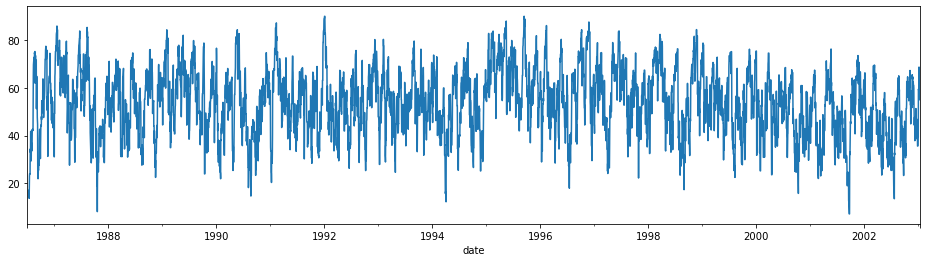

In [52]:
explore_df['relative'].plot(figsize = (16, 4))

In [53]:
# Got help from here; https://towardsdatascience.com/technical-analysis-of-stocks-using-ta-lib-305614165051
# And here: https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300

In [54]:
# # import needed libraries
# import pandas as pd
# import matplotlib.pyplot as plt
# from pandas_datareader import data as web

# # Make function for calls to Yahoo Finance
# def get_adj_close(ticker, start, end):
#     '''
#     A function that takes ticker symbols, starting period, ending period
#     as arguments and returns with a Pandas DataFrame of the Adjusted Close Prices
#     for the tickers from Yahoo Finance
#     '''
#     start = start
#     end = end
#     info = web.DataReader(ticker, data_source='yahoo', start=start, end=end)['Adj Close']
#     return pd.DataFrame(info)

# # Get Adjusted Closing Prices for Facebook, Tesla and Amazon between 2016-2017
# fb = get_adj_close('fb', '1/2/2016', '31/12/2017')
# tesla = get_adj_close('tsla', '1/2/2016', '31/12/2017')
# amazon = get_adj_close('amzn', '1/2/2016', '31/12/2017')

# # Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band
# for item in (fb, tesla, amazon):
#     item['30 Day MA'] = item['Adj Close'].rolling(window=20).mean()
    
#     # set .std(ddof=0) for population std instead of sample
#     item['30 Day STD'] = item['Adj Close'].rolling(window=20).std() 
    
#     item['Upper Band'] = item['30 Day MA'] + (item['30 Day STD'] * 2)
#     item['Lower Band'] = item['30 Day MA'] - (item['30 Day STD'] * 2)

# # Simple 30 Day Bollinger Band for Facebook (2016-2017)
# fb[['Adj Close', '30 Day MA', 'Upper Band', 'Lower Band']].plot(figsize=(12,6))
# plt.title('30 Day Bollinger Band for Facebook')
# plt.ylabel('Price (USD)')
# plt.show();

## Modeling

- Will be using Moving Average to create a forecast. Will attempt to use a 50 day and 200 day moving average.

In [55]:
train.head()

,spx
date,
1986-06-30,250.84
1986-07-01,252.04
1986-07-02,252.70
1986-07-03,251.79
1986-07-04,251.79


In [56]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [57]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [58]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [59]:
def make_predictions(stocks):
    yhat_df = pd.DataFrame({'spx': [stocks]}, index = validate.index)
    return yhat_df

In [60]:
eval_df

,model_type,target_var,rmse


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6040 entries, 1986-06-30 to 2003-01-11
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     6040 non-null   float64
dtypes: float64(1)
memory usage: 254.4 KB


### Last Observed Value

In [62]:
stocks = round(train['spx'][-1:][0])
stocks

928

In [63]:
yhat_df = pd.DataFrame({'spx': [stocks]}, index = validate.index)

yhat_df.head()
yhat_df.describe()

,spx
count,3624.0
mean,928.0
std,0.0
min,928.0
25%,928.0
50%,928.0
75%,928.0
max,928.0


spx -- RMSE: 329


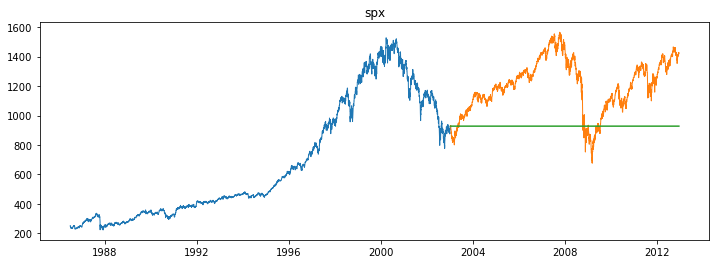

In [64]:
plot_and_eval('spx')

spx -- RMSE: 329


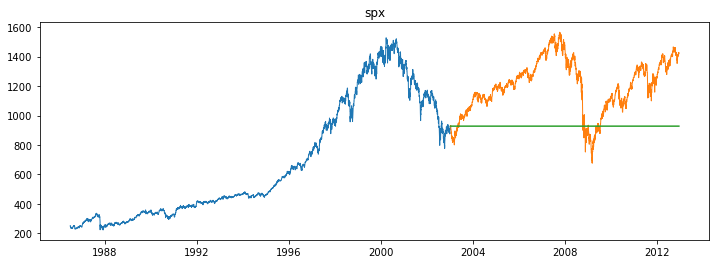

In [65]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

In [66]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)
    
eval_df

,model_type,target_var,rmse
0,last_observed_value,spx,329.0


### Simple Moving Average

In [71]:
# compute a 50 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 50

stocks = round(train['spx'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions(stocks_ma)
yhat_df.head(3)

,spx
date,
2003-01-12,907.48
2003-01-13,907.48
2003-01-14,907.48


In [72]:
yhat_df.describe()

,spx
count,3.624000e+03
mean,9.074800e+02
std,1.671427e-11
min,9.074800e+02
25%,9.074800e+02
50%,9.074800e+02
75%,9.074800e+02
max,9.074800e+02


spx -- RMSE: 347


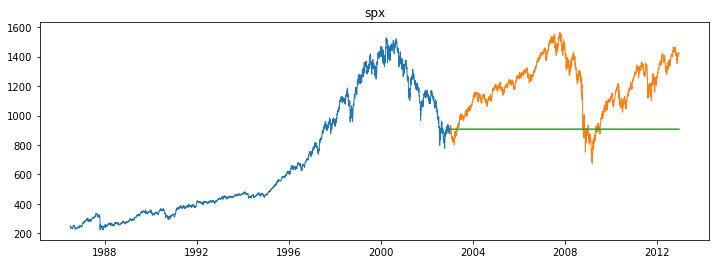

In [73]:
plot_and_eval('spx')

In [76]:
for col in train.columns:
    eval_df = append_eval_df(model_type='50d_moving_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,spx,329.0
1,50d_moving_average,spx,347.0


In [77]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,spx,329.0
1,50d_moving_average,spx,347.0


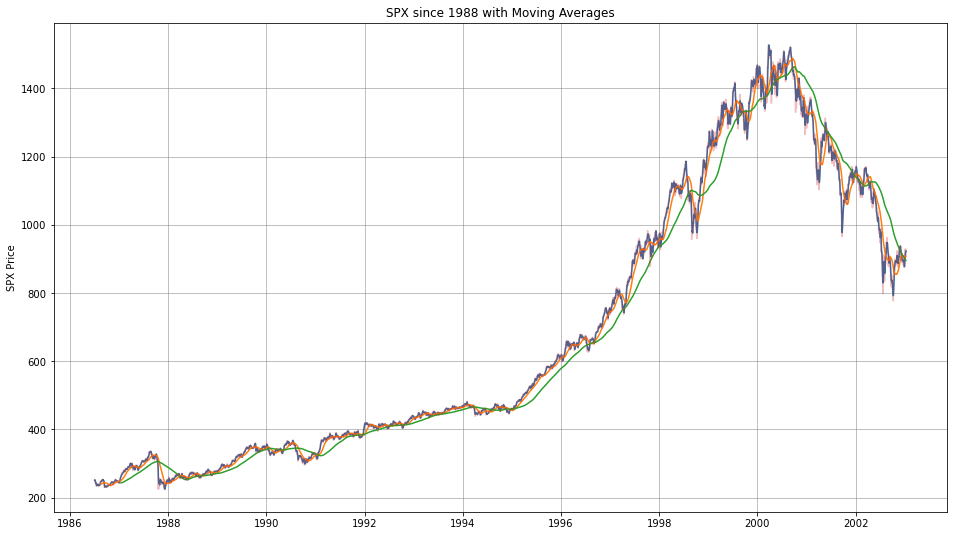

In [78]:
plt.figure(figsize=(16,9))
plt.plot(train['spx'].rolling(5).mean())
plt.plot(train['spx'].rolling(50).mean())
plt.plot(train['spx'].rolling(200).mean())
plt.plot(train['spx'], alpha=.3)
plt.grid(color = 'gray', linewidth = .50, which = "both")
plt.title("SPX since 1988 with Moving Averages")
plt.ylabel('SPX Price')
plt.show()

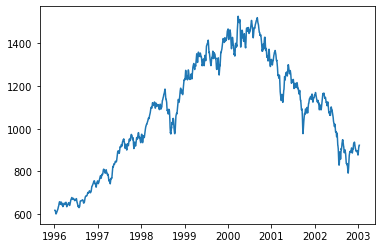

In [79]:
plt.plot(train['1996':]['spx'].rolling(5).mean())

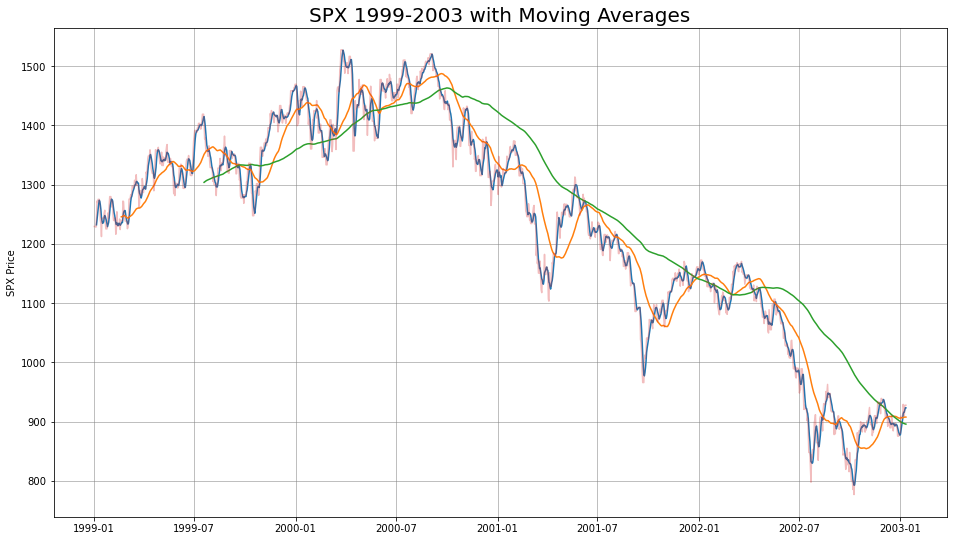

In [80]:
plt.figure(figsize=(16,9))
plt.plot(train['1999':]['spx'].rolling(5).mean())
plt.plot(train['1999':]['spx'].rolling(50).mean())
plt.plot(train['1999':]['spx'].rolling(200).mean())
plt.plot(train['1999':]['spx'], alpha=.3)
plt.grid(color = 'gray', linewidth = .50, which = "both")
plt.title("SPX 1999-2003 with Moving Averages", fontsize = 20)
plt.ylabel('SPX Price')
plt.show()

In [82]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    stocks = round(train['spx'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(stocks)
    model_type = str(p) + 'd_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [83]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,spx,329.0
1,50d_moving_average,spx,347.0
2,4d_moving_avg,spx,334.0
3,12d_moving_avg,spx,343.0
4,26d_moving_avg,spx,354.0
5,52d_moving_avg,spx,346.0
6,104d_moving_avg,spx,362.0


### Holt's Linear Trend

spx 



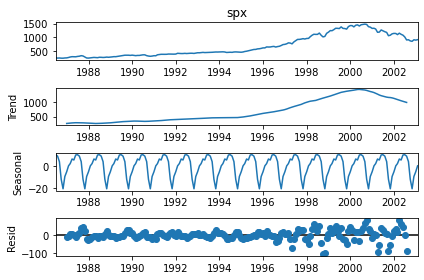

<Figure size 864x648 with 0 Axes>

In [84]:

# First, going to show the seasonal decomposition on a monthly basis. This should be interesting what the seasonal decompose thinks is random error in the stock market!

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.figure(figsize = (12, 9))
    plt.show()

In [85]:
yhat_df

,spx
date,
2003-01-12,890.1
2003-01-13,890.1
2003-01-14,890.1
2003-01-15,890.1
2003-01-16,890.1
...,...
2012-12-09,890.1
2012-12-10,890.1
2012-12-11,890.1


In [86]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,spx,329.0
1,50d_moving_average,spx,347.0
2,4d_moving_avg,spx,334.0
3,12d_moving_avg,spx,343.0
4,26d_moving_avg,spx,354.0
5,52d_moving_avg,spx,346.0
6,104d_moving_avg,spx,362.0


In [ ]:
# Like always when creating models; Make the thing, Fit the thing, and Use the thing.

# for col in train.columns:
#     model = Holt(train[col], exponential=False, damped=True)
#     model = model.fit(optimized=True)
#     yhat_stock = model.predict(start = validate.index[0],
#                                end = validate.index[-1])
#     yhat_df[col] = round(yhat_stock, 2)

In [87]:
model = Holt(train['spx'], exponential=False, damped=True)
model

In [88]:
model = model.fit(optimized=True)
model

In [89]:
yhat_stock = model.predict(start = validate.index[0], end = validate.index[-1])
yhat_stock

2003-01-12    927.577450
2003-01-13    927.584755
2003-01-14    927.591975
2003-01-15    927.599109
2003-01-16    927.606159
                 ...    
2012-12-09    928.196565
2012-12-10    928.196565
2012-12-11    928.196565
2012-12-12    928.196565
2012-12-13    928.196565
Freq: D, Length: 3624, dtype: float64

In [90]:
yhat_df[col] = round(yhat_stock, 2)
yhat_df

,spx
date,
2003-01-12,927.58
2003-01-13,927.58
2003-01-14,927.59
2003-01-15,927.60
2003-01-16,927.61
...,...
2012-12-09,928.20
2012-12-10,928.20
2012-12-11,928.20


In [ ]:
# for col in train.columns:
#     plot_and_eval(target_var = col)

spx -- RMSE: 329


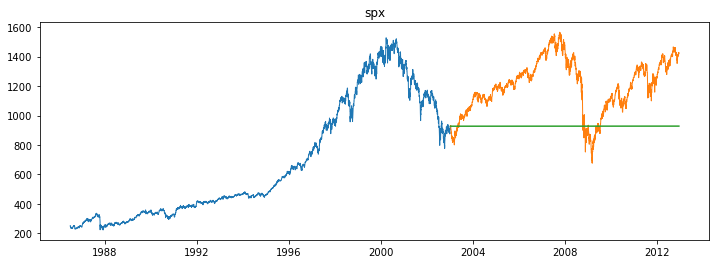

In [91]:
plot_and_eval('spx')

In [92]:

for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [93]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,spx,329.0
7,holts_optimized,spx,329.0
2,4d_moving_avg,spx,334.0
3,12d_moving_avg,spx,343.0
5,52d_moving_avg,spx,346.0
1,50d_moving_average,spx,347.0
4,26d_moving_avg,spx,354.0
6,104d_moving_avg,spx,362.0


#### Takeaway:

As odd as it seems, the Holt Linear Model doesn't appear to be much better than the last observed model. I double checked the functions and the code, and I'm not duplicating the last observed value's numbers. The Hold model does indeed come close to predicting the last observed number in the model.
- This leads me to believe that something in the Holt modeling itself is wrong, and I need to change the hyperparameters.

In [96]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level = .1, smoothing_slope = .1, optimized=False)
    yhat_stock = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_stock, 2)

In [97]:
yhat_df

,spx
date,
2003-01-12,905.70
2003-01-13,907.09
2003-01-14,908.49
2003-01-15,909.88
2003-01-16,911.27
...,...
2012-12-09,5943.24
2012-12-10,5944.63
2012-12-11,5946.02


spx -- RMSE: 2636


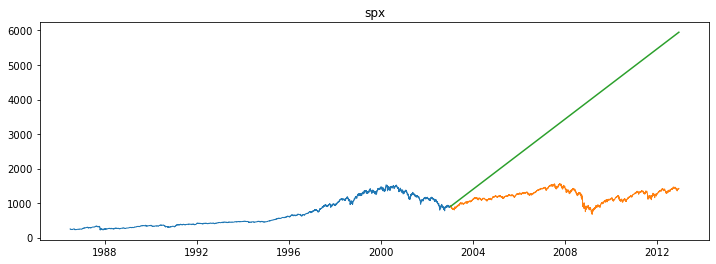

In [98]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [99]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,spx,329.0
7,holts_optimized,spx,329.0
2,4d_moving_avg,spx,334.0
3,12d_moving_avg,spx,343.0
5,52d_moving_avg,spx,346.0
1,50d_moving_average,spx,347.0
4,26d_moving_avg,spx,354.0
6,104d_moving_avg,spx,362.0
8,holts_.1,spx,2636.0


#### Takeaway:

- Tuning the hyperparameters in this way made the results even worse.
- I could spend more time on this, but taking a step back and looking at the big picture, I know that an average (which will basically produce a straight line) isn't going to be very accurate at the end of the day, so it's not worth putting extra time into it. Worth more to try out another model.

### FB Prophet

